## Анализ вакансий сайта hh.ru

## Обработка данных

### Загрузка данных из источника

In [46]:
#%pip install pandas
#%pip install numpy
import sqlite3
import pandas as pd
import numpy as np

con = sqlite3.connect("..\db\hhvacancy.db")
cur = con.cursor()
vacancies_frame = pd.read_sql("SELECT * FROM VacancyFullInfo", con)

### Конвертация валюты заработной платы в рубли

In [47]:
#%pip install requests

In [48]:
# %load wallet_converter
import requests
from xml.etree import ElementTree as ET

def get_exchange_rates(date):
    url = f'https://www.cbr.ru/scripts/XML_daily.asp?date_req={date}'
    response = requests.get(url)
    response.raise_for_status()  # Проверка успешности запроса
    return response.content

def parse_exchange_rates(xml_data):
    tree = ET.ElementTree(ET.fromstring(xml_data))
    root = tree.getroot()
    
    rates = {}
    for currency in root.findall('Valute'):
        char_code = currency.find('CharCode').text
        value = float(currency.find('Value').text.replace(',', '.'))
        nominal = float(currency.find('Nominal').text.replace(',', '.'))
        rates[char_code] = value / nominal
        
    rates['BYR'] = rates['BYN']
    return rates

def currency_not_rouble(currency):
    return (currency != 'RUB') and (currency != 'RUR')

def convert_currency_internal(amount, from_currency, to_currency, rates): 

    if currency_not_rouble(from_currency):
        amount = amount * rates[from_currency]

    if currency_not_rouble(to_currency):
        amount = amount / rates[to_currency]

    return amount


date = '16/06/2024'  # Дата в формате ДД/ММ/ГГГГ


xml_data = get_exchange_rates(date)
rates = parse_exchange_rates(xml_data)


def convert_currency(amount, from_currency, to_currency):
    return convert_currency_internal(amount, from_currency, to_currency, rates)



In [49]:
vacancies_frame["SalaryMiddleRub"] = vacancies_frame.apply(lambda row: convert_currency(row['SalaryMiddleClear'], row['SalaryCurrency'], 'RUB'), axis=1)

### Подготовка данных для обработки

In [50]:
# Удаление дубликатов
vacancies_frame.drop_duplicates(inplace=True)

# Обработка пропущенных значений
vacancies_frame.dropna(subset=['SalaryMiddleRub', 'ExperienceName', 'KeySkills', 'AreaName'], inplace=True)

# Преобразование категориальных данных с использованием one-hot encoding
categorical_columns = ['AreaName', 'ExperienceName']
vacancies_frame = pd.get_dummies(vacancies_frame, columns=categorical_columns)

# Разделение KeySkills и ProfessionalRoles на отдельные бинарные признаки
skills = vacancies_frame['KeySkills'].str.get_dummies(sep=',')
roles = vacancies_frame['ProfessionalRoles'].str.get_dummies(sep=',')

# Добавление новых бинарных признаков к основному DataFrame
vacancies_frame = pd.concat([vacancies_frame, skills, roles], axis=1)

# Определение зависимой и независимых переменных
X = vacancies_frame.drop(['SalaryMiddleRub'], axis=1)
y = vacancies_frame['SalaryMiddleRub']

## Информация о наборе данных

### Пример данных

In [51]:
vacancies_frame.head(10)

,VacancyId,VacancyName,EmployerName,HasTest,PublishedAt,ResponseLetterRequired,SalaryCurrency,SalaryFrom,SalaryTo,SalaryGross,...,Специалист по кадрам,Специалист по подбору персонала,Специалист по тендерам,Специалист службы безопасности,Специалист технической поддержки,Тестировщик,Технический писатель,Технолог,Упаковщик,Учитель
2,100426572,PHP / Laravel Developer (Удаленно),KingBoost,0,2024-06-15 00:35:01,1,USD,2000.0,3000.0,0,...,0,0,0,0,0,0,0,0,0,0
3,100426573,PHP / Laravel Developer (Удаленно),KingBoost,0,2024-06-15 00:35:01,1,USD,2000.0,3000.0,0,...,0,0,0,0,0,0,0,0,0,0
4,100426574,PHP / Laravel Developer (Удаленно),KingBoost,0,2024-06-15 00:35:01,1,USD,2000.0,3000.0,0,...,0,0,0,0,0,0,0,0,0,0
5,101973719,Fullstack PHP Developer (SalesRep.ai),Americor Funding Inc,1,2024-06-15 00:27:39,0,USD,3500.0,4500.0,0,...,0,0,0,0,0,0,0,0,0,0
6,101972784,Senior Golang программист,MartLive Inc.,0,2024-06-14 23:36:21,0,RUR,200000.0,300000.0,0,...,0,0,0,0,0,0,0,0,0,0
7,86258755,Middle/Senior SRE инженер,Биг Дата Технолоджи,0,2024-06-14 23:23:32,0,RUR,275000.0,375000.0,0,...,0,0,0,0,0,0,0,0,0,0
8,95846246,Go-разработчик,Фабрика Решений,0,2024-06-14 22:59:57,0,RUR,100000.0,270000.0,0,...,0,0,0,0,0,0,0,0,0,0
9,99434903,Мобильный разработчик iOS,Гладунова Евгения Сергеевна,0,2024-06-14 22:58:27,0,USD,2000.0,3500.0,0,...,0,0,0,0,0,0,0,0,0,0
10,99434904,Мобильный разработчик iOS,Гладунова Евгения Сергеевна,0,2024-06-14 22:58:27,0,USD,2000.0,3500.0,0,...,0,0,0,0,0,0,0,0,0,0
11,101008112,Frontend разработчик Angular Middle+,К2Т,0,2024-06-14 22:47:06,0,RUR,200000.0,NaN,0,...,0,0,0,0,0,0,0,0,0,0


### Информация о типах колонок

In [52]:
vacancies_frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1577 entries, 2 to 2381
Columns: 2281 entries, VacancyId to Учитель
dtypes: bool(170), float64(6), int64(2085), object(20)
memory usage: 25.7+ MB


### Описательные статистики

In [53]:
vacancies_frame.describe(include='all')

,VacancyId,VacancyName,EmployerName,HasTest,PublishedAt,ResponseLetterRequired,SalaryCurrency,SalaryFrom,SalaryTo,SalaryGross,...,Специалист по кадрам,Специалист по подбору персонала,Специалист по тендерам,Специалист службы безопасности,Специалист технической поддержки,Тестировщик,Технический писатель,Технолог,Упаковщик,Учитель
count,1577,1577,1576,1577.000000,1577,1577.000000,1577,1.348000e+03,9.470000e+02,1577.000000,...,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000
unique,1577,991,1102,NaN,1483,NaN,6,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,100426572,Специалист по информационной безопасности,РТК-Сервис,NaN,2024-05-23 14:56:29,NaN,RUR,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,77,18,NaN,6,NaN,1429,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.036145,NaN,0.025999,NaN,1.574982e+05,2.598336e+05,0.304375,...,0.001268,0.002536,0.000634,0.010146,0.027901,0.187064,0.000634,0.002536,0.000634,0.001902
std,NaN,NaN,NaN,0.186709,NaN,0.159182,NaN,5.652994e+05,1.180960e+06,0.460288,...,0.035601,0.050315,0.025182,0.100246,0.164742,0.390087,0.025182,0.050315,0.025182,0.043588
min,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,1.400000e+02,1.900000e+02,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,6.000000e+04,8.000000e+04,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,1.000000e+05,1.500000e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,1.662500e+05,2.500000e+05,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Анализ колонок

#### Конфигурация отрисовки графиков

In [54]:
#%pip install matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline


#### Гистограмма откликов по вакансиям с момента публикации

<Axes: >

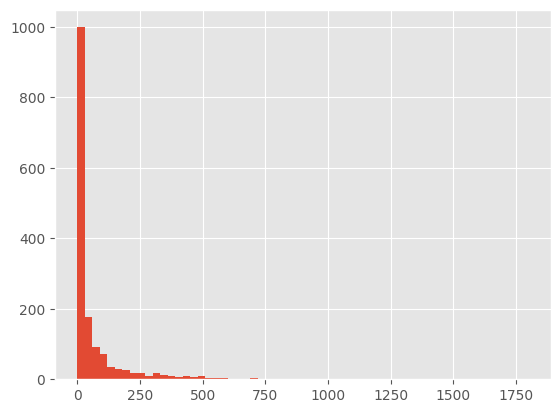

In [55]:
vacancies_frame["CountersResponses"].hist(bins=60)

#### Гистограмма откликов по вакансиям с момента создания вакансии

<Axes: >

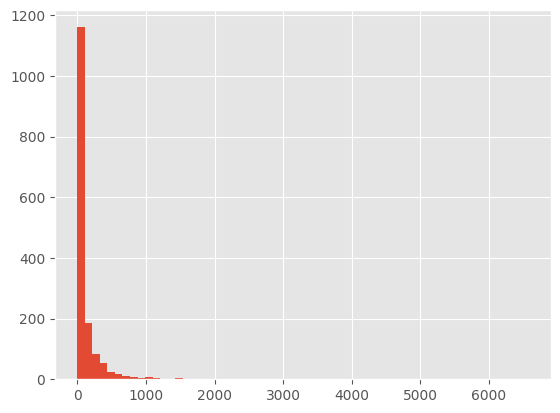

In [56]:
vacancies_frame["CountersTotalResponses"].hist(bins=60)

#### Гистограмма по средним зарплатам

<Axes: >

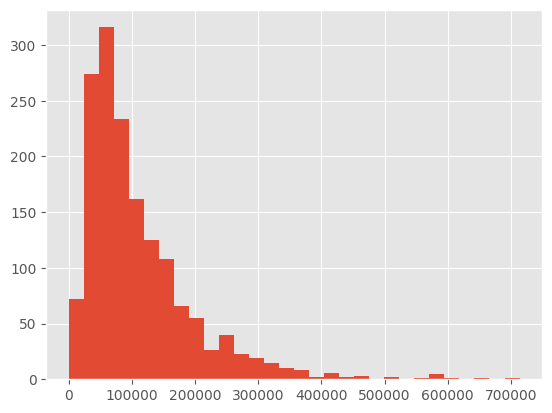

In [57]:
vacancies_frame["SalaryMiddleRub"].hist(bins=30)